In [22]:
!pip install CoolProp

In [23]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt

In [24]:
import CoolProp.CoolProp as CP

# Refrigerant
fluid = 'R134a'

# Conditions (in Kelvin)
T_evap = 278.15  # 5°C
T_cond = 308.15  # 35°C
eff_isentropic = 0.8

# --- State 1: Evaporator outlet (saturated vapor at T_evap) ---
P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)
T1 = T_evap
h1 = PropsSI('H', 'T', T_evap, 'Q', 1, fluid)
s1 = PropsSI('S', 'T', T_evap, 'Q', 1, fluid)

# --- State 2s: Isentropic compression to condenser pressure ---
P2 = PropsSI('P', 'T', T_cond, 'Q', 1, fluid)
s2s = s1
h2s = PropsSI('H', 'P', P2, 'S', s1, fluid)

# Actual outlet (State 2) considering isentropic efficiency
h2 = h1 + (h2s - h1) / eff_isentropic
T2 = PropsSI('T', 'P', P2, 'H', h2, fluid)
s2 = PropsSI('S', 'P', P2, 'H', h2, fluid)

# --- State 3: Condenser outlet (saturated liquid) ---
T3 = T_cond
h3 = PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
s3 = PropsSI('S', 'T', T_cond, 'Q', 0, fluid)

# --- State 4: After expansion valve (isenthalpic expansion to P1) ---
h4 = h3
P4 = P1
T4 = PropsSI('T', 'P', P4, 'H', h4, fluid)
s4 = PropsSI('S', 'P', P4, 'H', h4, fluid)

# --- Print all values ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P/1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h/1000:.2f} kJ/kg")
    print(f"  Entropy      = {s/1000:.4f} kJ/kg·K\n")

print_state(1, P1, T1, h1, s1)
print_state(2, P2, T2, h2, s2)
print_state(3, P2, T3, h3, s3)
print_state(4, P1, T4, h4, s4)

# --- Optional: Performance summary ---
q_in = h1 - h4
w_in = h2 - h1
COP = q_in / w_in

print(f"Cooling Capacity (q_in): {q_in/1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in/1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP:.2f}")

Total_Power=77000000  #77MW
m_flow_rate=Total_Power/q_in

print(f"Mass Flow Rate : {m_flow_rate:.2f} kg/s")


State 1:
  Pressure     = 3.50 bar
  Temperature  = 5.00 °C
  Enthalpy     = 401.49 kJ/kg
  Entropy      = 1.7245 kJ/kg·K

State 2:
  Pressure     = 8.87 bar
  Temperature  = 42.82 °C
  Enthalpy     = 425.63 kJ/kg
  Entropy      = 1.7399 kJ/kg·K

State 3:
  Pressure     = 8.87 bar
  Temperature  = 35.00 °C
  Enthalpy     = 249.01 kJ/kg
  Entropy      = 1.1670 kJ/kg·K

State 4:
  Pressure     = 3.50 bar
  Temperature  = 5.00 °C
  Enthalpy     = 249.01 kJ/kg
  Entropy      = 1.1762 kJ/kg·K

Cooling Capacity (q_in): 152.49 kJ/kg
Compressor Work (w_in): 24.14 kJ/kg
Coefficient of Performance (COP): 6.32
Mass Flow Rate : 504.97 kg/s


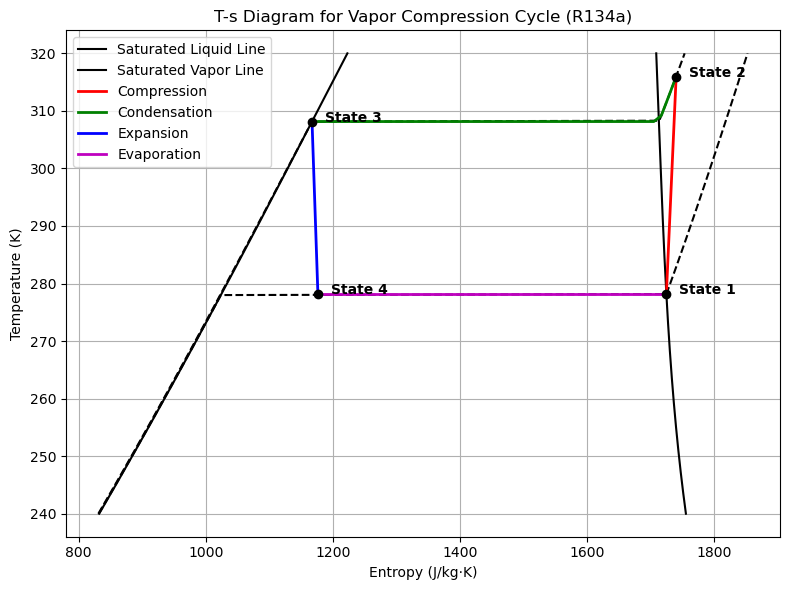

In [25]:
# T-s diagram
plt.figure(figsize=(8,6))

# Saturation lines
Tsat = np.linspace(240, 320, 500)
sliq = [PropsSI('S', 'T', t, 'Q', 0, fluid) for t in Tsat]
svap = [PropsSI('S', 'T', t, 'Q', 1, fluid) for t in Tsat]
plt.plot(sliq, Tsat, 'k-', label='Saturated Liquid Line')
plt.plot(svap, Tsat, 'k-', label='Saturated Vapor Line')

T = np.linspace(240, 320, 500)
for P in [P1,P2]: #MPa
    S = [PropsSI('S','P',P,'T',t,fluid) for t in T]
    plt.plot(S, T, 'k--')

# Refrigeration cycle
plt.plot([s1, s2], [T1, T2], 'r-', lw=2, label='Compression')

S23 = np.linspace(s2, s3)
T23 = [PropsSI('T','P',P2,'S',s,fluid) for s in S23]
plt.plot(S23,T23, 'g-', lw=2, label='Condensation')

plt.plot([s3, s4], [T3, T4], 'b-', lw=2, label='Expansion')
plt.plot([s4, s1], [T4, T1], 'm-', lw=2, label='Evaporation')



# State points
states = [(s1, T1), (s2, T2), (s3, T3), (s4, T4)]
for i, (s, T) in enumerate(states, start=1):
    plt.plot(s, T, 'ko')  # point
    plt.text(s + 20, T, f"State {i}", fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel('Entropy (J/kg·K)')
plt.ylabel('Temperature (K)')
plt.title('T-s Diagram for Vapor Compression Cycle (R134a)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

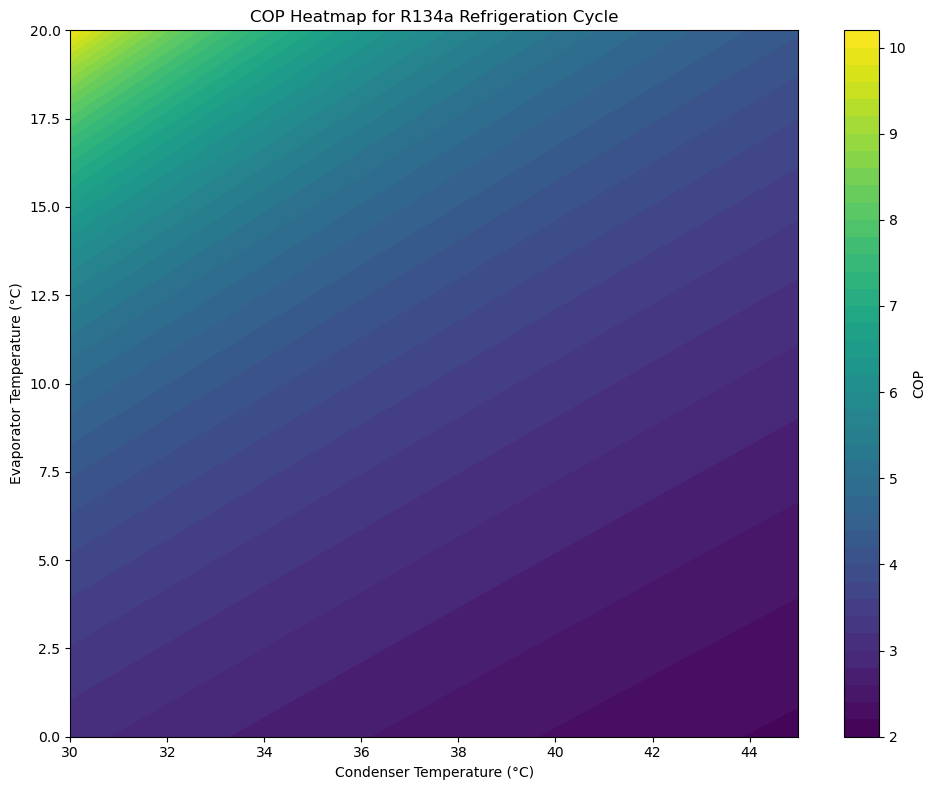

In [26]:
# Cooling Load (in kW)
cooling_load = 77000  # 77 MW

# Evaporator (T_evap) and Condenser (T_cond) temperature ranges
T_evap_range = np.linspace(273.15, 293.15, 20)  # Evaporator: 0 to 20°C
T_cond_range = np.linspace(303.15, 318.15, 20)  # Condenser: 30 to 45°C

# Initialize COP matrix
COP_matrix = np.zeros((len(T_evap_range), len(T_cond_range)))

# Parametric sweep over Evap and Cond temperatures
for i, T_evap in enumerate(T_evap_range):
    for j, T_cond in enumerate(T_cond_range):
        # State 1: Saturated vapor at evaporator outlet
        P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)  # Saturated vapor at evaporator
        h1 = PropsSI('H', 'P', P1, 'Q', 1, fluid)
        s1 = PropsSI('S', 'P', P1, 'Q', 1, fluid)

        # State 2: Isentropic compression to condenser pressure
        P2 = PropsSI('P', 'T', T_cond, 'Q', 0, fluid)  # Saturated liquid at condenser
        h2s = PropsSI('H', 'P', P2, 'S', s1, fluid)
        h2 = h1 + (h2s - h1) / 0.8  # 80% efficiency
        s2 = PropsSI('S', 'P', P2, 'H', h2, fluid)

        # State 3: Saturated liquid at condenser outlet
        h3 = PropsSI('H', 'P', P2, 'Q', 0, fluid)
        s3 = PropsSI('S', 'P', P2, 'Q', 0, fluid)

        # State 4: Expansion (isenthalpic) to evaporator pressure
        h4 = h3
        P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)
        T4 = PropsSI('T', 'P', P1, 'H', h4, fluid)
        s4 = PropsSI('S', 'P', P1, 'H', h4, fluid)

        # Calculate Work (compressor) and COP
        W_compressor = h2 - h1  # Work done by the compressor
        COP = cooling_load / W_compressor  # COP calculation (simplified)

        # Store the COP for this T_evap and T_cond
        COP_matrix[i, j] = COP

# Plotting the heatmap
plt.figure(figsize=(10, 8))
X, Y = np.meshgrid(T_cond_range - 273.15, T_evap_range - 273.15)  # Convert to Celsius
plt.contourf(X, Y, COP_matrix, levels=50, cmap='viridis')
plt.colorbar(label="COP")

plt.xlabel('Condenser Temperature (°C)')
plt.ylabel('Evaporator Temperature (°C)')
plt.title('COP Heatmap for R134a Refrigeration Cycle')
plt.tight_layout()
plt.show()

In [27]:
import CoolProp.CoolProp as CP

# Refrigerant
fluid = 'R134a'

# Conditions (in Kelvin)
T_evap = 293.15  
T_cond = 303.15  
eff_isentropic = 0.8

# --- State 1: Evaporator outlet (saturated vapor at T_evap) ---
P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)
T1 = T_evap
h1 = PropsSI('H', 'T', T_evap, 'Q', 1, fluid)
s1 = PropsSI('S', 'T', T_evap, 'Q', 1, fluid)

# --- State 2s: Isentropic compression to condenser pressure ---
P2 = PropsSI('P', 'T', T_cond, 'Q', 1, fluid)
s2s = s1
h2s = PropsSI('H', 'P', P2, 'S', s1, fluid)

# Actual outlet (State 2) considering isentropic efficiency
h2 = h1 + (h2s - h1) / eff_isentropic
T2 = PropsSI('T', 'P', P2, 'H', h2, fluid)
s2 = PropsSI('S', 'P', P2, 'H', h2, fluid)

# --- State 3: Condenser outlet (saturated liquid) ---
T3 = T_cond
h3 = PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
s3 = PropsSI('S', 'T', T_cond, 'Q', 0, fluid)

# --- State 4: After expansion valve (isenthalpic expansion to P1) ---
h4 = h3
P4 = P1
T4 = PropsSI('T', 'P', P4, 'H', h4, fluid)
s4 = PropsSI('S', 'P', P4, 'H', h4, fluid)

# --- Print all values ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P/1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h/1000:.2f} kJ/kg")
    print(f"  Entropy      = {s/1000:.4f} kJ/kg·K\n")

print_state(1, P1, T1, h1, s1)
print_state(2, P2, T2, h2, s2)
print_state(3, P2, T3, h3, s3)
print_state(4, P1, T4, h4, s4)

# --- Optional: Performance summary ---
q_in = h1 - h4
w_in = h2 - h1
COP = q_in / w_in

print(f"Cooling Capacity (q_in): {q_in/1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in/1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP:.2f}")


State 1:
  Pressure     = 5.72 bar
  Temperature  = 20.00 °C
  Enthalpy     = 409.75 kJ/kg
  Entropy      = 1.7180 kJ/kg·K

State 2:
  Pressure     = 7.70 bar
  Temperature  = 32.47 °C
  Enthalpy     = 417.43 kJ/kg
  Entropy      = 1.7231 kJ/kg·K

State 3:
  Pressure     = 7.70 bar
  Temperature  = 30.00 °C
  Enthalpy     = 241.72 kJ/kg
  Entropy      = 1.1435 kJ/kg·K

State 4:
  Pressure     = 5.72 bar
  Temperature  = 20.00 °C
  Enthalpy     = 241.72 kJ/kg
  Entropy      = 1.1449 kJ/kg·K

Cooling Capacity (q_in): 168.03 kJ/kg
Compressor Work (w_in): 7.68 kJ/kg
Coefficient of Performance (COP): 21.86


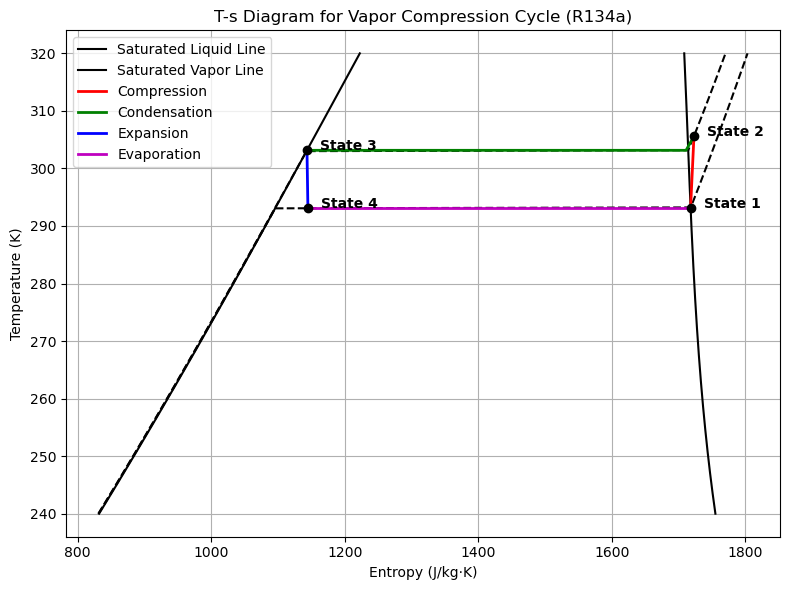

In [28]:
# T-s diagram
plt.figure(figsize=(8,6))

# Saturation lines
Tsat = np.linspace(240, 320, 500)
sliq = [PropsSI('S', 'T', t, 'Q', 0, fluid) for t in Tsat]
svap = [PropsSI('S', 'T', t, 'Q', 1, fluid) for t in Tsat]
plt.plot(sliq, Tsat, 'k-', label='Saturated Liquid Line')
plt.plot(svap, Tsat, 'k-', label='Saturated Vapor Line')

T = np.linspace(240, 320, 500)
for P in [P1,P2]: #MPa
    S = [PropsSI('S','P',P,'T',t,fluid) for t in T]
    plt.plot(S, T, 'k--')

# Refrigeration cycle
plt.plot([s1, s2], [T1, T2], 'r-', lw=2, label='Compression')

S23 = np.linspace(s2, s3)
T23 = [PropsSI('T','P',P2,'S',s,fluid) for s in S23]
plt.plot(S23,T23, 'g-', lw=2, label='Condensation')

plt.plot([s3, s4], [T3, T4], 'b-', lw=2, label='Expansion')
plt.plot([s4, s1], [T4, T1], 'm-', lw=2, label='Evaporation')



# State points
states = [(s1, T1), (s2, T2), (s3, T3), (s4, T4)]
for i, (s, T) in enumerate(states, start=1):
    plt.plot(s, T, 'ko')  # point
    plt.text(s + 20, T, f"State {i}", fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel('Entropy (J/kg·K)')
plt.ylabel('Temperature (K)')
plt.title('T-s Diagram for Vapor Compression Cycle (R134a)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
import CoolProp.CoolProp as CP
import numpy as np

fluid = 'R134a'
Tevap = 5 + 273.15  # K
Tcond = 35 + 273.15   # K
eta_isentropic = 0.8  # compressor efficiency

# Get pressures
P1 = CP.PropsSI('P', 'T', Tevap, 'Q', 1, fluid)  # Evaporator pressure
P5 = CP.PropsSI('P', 'T', Tcond, 'Q', 0, fluid)  # Condenser pressure
P3 = np.sqrt(P1 * P5)                            # Intermediate pressure (geometric mean)

# --- State 1: Evaporator outlet ---
h1 = CP.PropsSI('H', 'P', P1, 'Q', 1, fluid)
s1 = CP.PropsSI('S', 'P', P1, 'Q', 1, fluid)
T1 = CP.PropsSI('T', 'P', P1, 'Q', 1, fluid)

# --- State 2s: Isentropic LP compression to P3 ---
h2s = CP.PropsSI('H', 'P', P3, 'S', s1, fluid)
h2 = h1 + (h2s - h1) / eta_isentropic
T2 = CP.PropsSI('T', 'P', P3, 'H', h2, fluid)
s2 = CP.PropsSI('S', 'P', P3, 'H', h2, fluid)

# --- State 3: After intercooler (saturated vapor at P3) ---
h3 = CP.PropsSI('H', 'P', P3, 'Q', 1, fluid)
T3 = CP.PropsSI('T', 'P', P3, 'Q', 1, fluid)
s3 = CP.PropsSI('S', 'P', P3, 'Q', 1, fluid)

# --- State 4s: Isentropic HP compression to condenser ---
h4s = CP.PropsSI('H', 'P', P5, 'S', s3, fluid)
h4 = h3 + (h4s - h3) / eta_isentropic
T4 = CP.PropsSI('T', 'P', P5, 'H', h4, fluid)
s4 = CP.PropsSI('S', 'P', P5, 'H', h4, fluid)

# --- State 5: Condenser outlet (saturated liquid) ---
h5 = CP.PropsSI('H', 'P', P5, 'Q', 0, fluid)
T5 = CP.PropsSI('T', 'P', P5, 'Q', 0, fluid)
s5 = CP.PropsSI('S', 'P', P5, 'Q', 0, fluid)

# --- State 6: Expansion to intermediate pressure (flash valve) ---
h6 = h5
T6 = CP.PropsSI('T', 'P', P3, 'H', h6, fluid)
s6 = CP.PropsSI('S', 'P', P3, 'H', h6, fluid)

# --- State 6: Expansion to intermediate pressure (flash valve) ---
h7 = CP.PropsSI('H', 'P', P3, 'Q', 0, fluid)
T7 = CP.PropsSI('T', 'P', P3, 'Q', 0, fluid)
s7 = CP.PropsSI('S', 'P', P3, 'Q', 0, fluid)

# --- State 8: Expansion to evaporator pressure ---
h8 = h7
T8 = CP.PropsSI('T', 'P', P1, 'H', h8, fluid)
s8 = CP.PropsSI('S', 'P', P1, 'H', h8, fluid)



# --- Print results ---
states = {
    '1': (P1, T1, h1, s1),
    '2': (P3, T2, h2, s2),
    '3': (P3, T3, h3, s3),
    '4': (P5, T4, h4, s4),
    '5': (P5, T5, h5, s5),
    '6': (P3, T6, h6, s6),
    '7': (P3, T7, h7, s7),
    '8': (P1, T8, h8, s8)
}

print("State\tP (bar)\tT (°C)\th (kJ/kg)\ts (kJ/kg·K)")
for k, (P, T, h, s) in states.items():
    print(f"{k}\t{P/1e5:.2f}\t{T-273.15:.2f}\t{h/1000:.2f}\t{s/1000:.4f}")




# --- Optional: Performance summary ---
q_in = h1 - h8
w_in = h2 - h1 + h4 - h3
COP = q_in / w_in

print(f"Cooling Capacity (q_in): {q_in/1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in/1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP:.2f}")


State	P (bar)	T (°C)	h (kJ/kg)	s (kJ/kg·K)
1	3.50	5.00	401.49	1.7245
2	5.57	23.39	413.49	1.7326
3	5.57	19.15	409.30	1.7184
4	8.87	38.78	421.31	1.7261
5	8.87	35.00	249.01	1.1670
6	5.57	19.15	249.01	1.1700
7	5.57	19.15	226.28	1.0922
8	3.50	5.00	226.28	1.0945
Cooling Capacity (q_in): 175.21 kJ/kg
Compressor Work (w_in): 24.01 kJ/kg
Coefficient of Performance (COP): 7.30


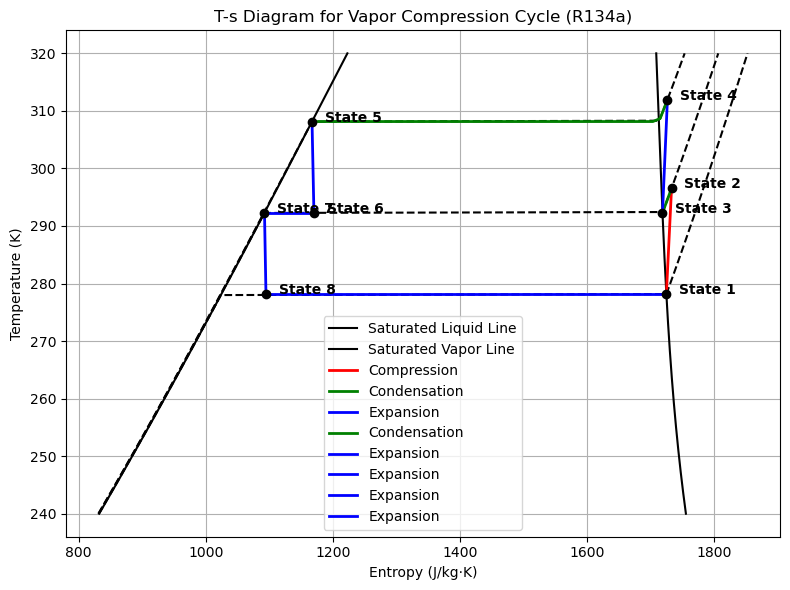

In [30]:
# T-s diagram
plt.figure(figsize=(8,6))

# Saturation lines
Tsat = np.linspace(240, 320, 500)
sliq = [PropsSI('S', 'T', t, 'Q', 0, fluid) for t in Tsat]
svap = [PropsSI('S', 'T', t, 'Q', 1, fluid) for t in Tsat]
plt.plot(sliq, Tsat, 'k-', label='Saturated Liquid Line')
plt.plot(svap, Tsat, 'k-', label='Saturated Vapor Line')

T = np.linspace(240, 320, 500)
for P in [P1,P3,P5]: #MPa
    S = [PropsSI('S','P',P,'T',t,fluid) for t in T]
    plt.plot(S, T, 'k--')

# Refrigeration cycle
plt.plot([s1, s2], [T1, T2], 'r-', lw=2, label='Compression')

S23 = np.linspace(s2, s3)
T23 = [PropsSI('T','P',P3,'S',s,fluid) for s in S23]
plt.plot(S23,T23, 'g-', lw=2, label='Condensation')

plt.plot([s3, s4], [T3, T4], 'b-', lw=2, label='Expansion')


S45 = np.linspace(s4, s5)
T45 = [PropsSI('T','P',P5,'S',s,fluid) for s in S45]
plt.plot(S45,T45, 'g-', lw=2, label='Condensation')

plt.plot([s5, s6], [T5, T6], 'b-', lw=2, label='Expansion')
plt.plot([s6, s7], [T6, T7], 'b-', lw=2, label='Expansion')
plt.plot([s7, s8], [T7, T8], 'b-', lw=2, label='Expansion')
plt.plot([s8, s1], [T8, T1], 'b-', lw=2, label='Expansion')

# State points
states = [(s1, T1), (s2, T2), (s3, T3), (s4, T4), (s5, T5), (s6, T6),(s7,T7), (s8, T8)]
for i, (s, T) in enumerate(states, start=1):
    plt.plot(s, T, 'ko')  # point
    plt.text(s + 20, T, f"State {i}", fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel('Entropy (J/kg·K)')
plt.ylabel('Temperature (K)')
plt.title('T-s Diagram for Vapor Compression Cycle (R134a)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
import CoolProp.CoolProp as CP

# Refrigerant
fluid = 'NH3'

# Conditions 
T_evap = -15 + 273.15
T_cond = 30 + 273.15
eff_isentropic = 0.8

# --- State 1: Evaporator outlet (saturated vapor at T_evap) ---
P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)
T1 = T_evap
h1 = PropsSI('H', 'T', T_evap, 'Q', 1, fluid)
s1 = PropsSI('S', 'T', T_evap, 'Q', 1, fluid)

# --- State 2s: Isentropic compression to condenser pressure ---
P2 = PropsSI('P', 'T', T_cond, 'Q', 1, fluid)
s2s = s1
h2s = PropsSI('H', 'P', P2, 'S', s1, fluid)

# Actual outlet (State 2) considering isentropic efficiency
h2 = h1 + (h2s - h1) / eff_isentropic
T2 = PropsSI('T', 'P', P2, 'H', h2, fluid)
s2 = PropsSI('S', 'P', P2, 'H', h2, fluid)

# --- State 3: Condenser outlet (saturated liquid) ---
T3 = T_cond
h3 = PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
s3 = PropsSI('S', 'T', T_cond, 'Q', 0, fluid)

# --- State 4: After expansion valve (isenthalpic expansion to P1) ---
h4 = h3
P4 = P1
T4 = PropsSI('T', 'P', P4, 'H', h4, fluid)
s4 = PropsSI('S', 'P', P4, 'H', h4, fluid)

# --- Print all values ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P/1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h/1000:.2f} kJ/kg")
    print(f"  Entropy      = {s/1000:.4f} kJ/kg·K\n")

print_state(1, P1, T1, h1, s1)
print_state(2, P2, T2, h2, s2)
print_state(3, P2, T3, h3, s3)
print_state(4, P1, T4, h4, s4)

# --- Optional: Performance summary ---
q_in = h1 - h4
w_in = h2 - h1
COP = q_in / w_in

print(f"Cooling Capacity (q_in): {q_in/1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in/1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP:.2f}")










State 1:
  Pressure     = 2.36 bar
  Temperature  = -15.00 °C
  Enthalpy     = 1589.68 kJ/kg
  Entropy      = 6.3110 kJ/kg·K

State 2:
  Pressure     = 11.67 bar
  Temperature  = 121.93 °C
  Enthalpy     = 1878.67 kJ/kg
  Entropy      = 6.4618 kJ/kg·K

State 3:
  Pressure     = 11.67 bar
  Temperature  = 30.00 °C
  Enthalpy     = 487.25 kJ/kg
  Entropy      = 1.9709 kJ/kg·K

State 4:
  Pressure     = 2.36 bar
  Temperature  = -15.00 °C
  Enthalpy     = 487.25 kJ/kg
  Entropy      = 2.0405 kJ/kg·K

Cooling Capacity (q_in): 1102.43 kJ/kg
Compressor Work (w_in): 289.00 kJ/kg
Coefficient of Performance (COP): 3.81


In [32]:
import CoolProp.CoolProp as CP

# Refrigerant
fluid = 'CO2'

# Conditions (in Kelvin)
T_evap = -50 + 273  
T_cond = -10 + 273  
eff_isentropic = 0.8

# --- State 1: Evaporator outlet (saturated vapor at T_evap) ---
P1 = PropsSI('P', 'T', T_evap, 'Q', 1, fluid)
T1 = T_evap
h1 = PropsSI('H', 'T', T_evap, 'Q', 1, fluid)
s1 = PropsSI('S', 'T', T_evap, 'Q', 1, fluid)

# --- State 2s: Isentropic compression to condenser pressure ---
P2 = PropsSI('P', 'T', T_cond, 'Q', 1, fluid)
s2s = s1
h2s = PropsSI('H', 'P', P2, 'S', s1, fluid)

# Actual outlet (State 2) considering isentropic efficiency
h2 = h1 + (h2s - h1) / eff_isentropic
T2 = PropsSI('T', 'P', P2, 'H', h2, fluid)
s2 = PropsSI('S', 'P', P2, 'H', h2, fluid)

# --- State 3: Condenser outlet (saturated liquid) ---
T3 = T_cond
h3 = PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
s3 = PropsSI('S', 'T', T_cond, 'Q', 0, fluid)

# --- State 4: After expansion valve (isenthalpic expansion to P1) ---
h4 = h3
P4 = P1
T4 = PropsSI('T', 'P', P4, 'H', h4, fluid)
s4 = PropsSI('S', 'P', P4, 'H', h4, fluid)



# --- Print all values ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P/1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h/1000:.2f} kJ/kg")
    print(f"  Entropy      = {s/1000:.4f} kJ/kg·K\n")

print_state(1, P1, T1, h1, s1)
print_state(2, P2, T2, h2, s2)
print_state(3, P2, T3, h3, s3)
print_state(4, P1, T4, h4, s4)

# --- Optional: Performance summary ---
q_in = h1 - h4
w_in = h2 - h1
COP = q_in / w_in

print(f"Cooling Capacity (q_in): {q_in/1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in/1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP:.2f}")


State 1:
  Pressure     = 6.78 bar
  Temperature  = -50.15 °C
  Enthalpy     = 432.63 kJ/kg
  Entropy      = 2.1027 kJ/kg·K

State 2:
  Pressure     = 26.37 bar
  Temperature  = 52.38 °C
  Enthalpy     = 508.32 kJ/kg
  Entropy      = 2.1502 kJ/kg·K

State 3:
  Pressure     = 26.37 bar
  Temperature  = -10.15 °C
  Enthalpy     = 176.18 kJ/kg
  Entropy      = 0.9145 kJ/kg·K

State 4:
  Pressure     = 6.78 bar
  Temperature  = -50.15 °C
  Enthalpy     = 176.18 kJ/kg
  Entropy      = 0.9527 kJ/kg·K

Cooling Capacity (q_in): 256.45 kJ/kg
Compressor Work (w_in): 75.69 kJ/kg
Coefficient of Performance (COP): 3.39


In [33]:
from CoolProp.CoolProp import PropsSI

# Refrigerant for high temp cycle
fluid_ht = 'Ammonia'

# Conditions (K)
T_cond_ht = 35 + 273.15       # NH3 condenser temp
T_evap_ht = -10 + 273.15      # NH3 evaporator (cooling CO2 condenser)
eff_isentropic_ht = 0.8

# --- State 5: Evaporator outlet (saturated vapor at T_evap_ht) ---
P5 = PropsSI('P', 'T', T_evap_ht, 'Q', 1, fluid_ht)
T5 = T_evap_ht
h5 = PropsSI('H', 'T', T_evap_ht, 'Q', 1, fluid_ht)
s5 = PropsSI('S', 'T', T_evap_ht, 'Q', 1, fluid_ht)

# --- State 6s: Isentropic compression to P6 (condenser pressure) ---
P6 = PropsSI('P', 'T', T_cond_ht, 'Q', 0, fluid_ht)
h6s = PropsSI('H', 'P', P6, 'S', s5, fluid_ht)

# Actual compressor outlet
h6 = h5 + (h6s - h5) / eff_isentropic_ht
T6 = PropsSI('T', 'P', P6, 'H', h6, fluid_ht)
s6 = PropsSI('S', 'P', P6, 'H', h6, fluid_ht)

# --- State 7: Condenser outlet (saturated liquid) ---
T7 = T_cond_ht
h7 = PropsSI('H', 'T', T_cond_ht, 'Q', 0, fluid_ht)
s7 = PropsSI('S', 'T', T_cond_ht, 'Q', 0, fluid_ht)

# --- State 8: After expansion valve to P5 (evaporator pressure) ---
h8 = h7
P8 = P5
T8 = PropsSI('T', 'P', P8, 'H', h8, fluid_ht)
s8 = PropsSI('S', 'P', P8, 'H', h8, fluid_ht)

# --- Print states for HT cycle ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P/1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h/1000:.2f} kJ/kg")
    print(f"  Entropy      = {s/1000:.4f} kJ/kg·K\n")

print("\n--- HIGH-TEMPERATURE CYCLE (NH₃) ---\n")
print_state(5, P5, T5, h5, s5)
print_state(6, P6, T6, h6, s6)
print_state(7, P6, T7, h7, s7)
print_state(8, P5, T8, h8, s8)

# Performance of HT cycle
q_in_ht = h5 - h8
w_in_ht = h6 - h5
COP_ht = q_in_ht / w_in_ht


print(f"HT Cooling Capacity (q_in): {q_in_ht/1000:.2f} kJ/kg")
print(f"HT Compressor Work (w_in): {w_in_ht/1000:.2f} kJ/kg")
print(f"HT Coefficient of Performance (COP): {COP_ht:.2f}")



--- HIGH-TEMPERATURE CYCLE (NH₃) ---

State 5:
  Pressure     = 2.91 bar
  Temperature  = -10.00 °C
  Enthalpy     = 1595.95 kJ/kg
  Entropy      = 6.2387 kJ/kg·K

State 6:
  Pressure     = 13.50 bar
  Temperature  = 122.33 °C
  Enthalpy     = 1874.73 kJ/kg
  Entropy      = 6.3838 kJ/kg·K

State 7:
  Pressure     = 13.50 bar
  Temperature  = 35.00 °C
  Enthalpy     = 511.56 kJ/kg
  Entropy      = 2.0494 kJ/kg·K

State 8:
  Pressure     = 2.91 bar
  Temperature  = -10.00 °C
  Enthalpy     = 511.56 kJ/kg
  Entropy      = 2.1179 kJ/kg·K

HT Cooling Capacity (q_in): 1084.39 kJ/kg
HT Compressor Work (w_in): 278.78 kJ/kg
HT Coefficient of Performance (COP): 3.89


In [65]:
from CoolProp.CoolProp import PropsSI

# Common parameters
eff_isentropic = 0.8

# --- NH3 CYCLE ---
fluid1 = 'NH3'
T_evap1 = -15 + 273.15
T_cond1 = 30 + 273.15

# State 1: Evaporator outlet (saturated vapor)
P1 = PropsSI('P', 'T', T_evap1, 'Q', 1, fluid1)
T1 = T_evap1
h1 = PropsSI('H', 'T', T_evap1, 'Q', 1, fluid1)
s1 = PropsSI('S', 'T', T_evap1, 'Q', 1, fluid1)

# State 2: After compression (actual)
P2 = PropsSI('P', 'T', T_cond1, 'Q', 1, fluid1)
h2s = PropsSI('H', 'P', P2, 'S', s1, fluid1)
h2 = h1 + (h2s - h1) / eff_isentropic
T2 = PropsSI('T', 'P', P2, 'H', h2, fluid1)
s2 = PropsSI('S', 'P', P2, 'H', h2, fluid1)

# State 3: Condenser outlet (saturated liquid)
T3 = T_cond1
h3 = PropsSI('H', 'T', T_cond1, 'Q', 0, fluid1)
s3 = PropsSI('S', 'T', T_cond1, 'Q', 0, fluid1)

# State 4: After expansion valve
h4 = h3
P4 = P1
T4 = PropsSI('T', 'P', P4, 'H', h4, fluid1)
s4 = PropsSI('S', 'P', P4, 'H', h4, fluid1)

# --- CO2 CYCLE ---
fluid2 = 'CO2'
T_evap2 = -50 + 273.15
T_cond2 = -10 + 273.15

# State 5: Evaporator outlet (saturated vapor)
P5 = PropsSI('P', 'T', T_evap2, 'Q', 1, fluid2)
T5 = T_evap2
h5 = PropsSI('H', 'T', T_evap2, 'Q', 1, fluid2)
s5 = PropsSI('S', 'T', T_evap2, 'Q', 1, fluid2)

# State 6: After compression (actual)
P6 = PropsSI('P', 'T', T_cond2, 'Q', 1, fluid2)
h6s = PropsSI('H', 'P', P6, 'S', s5, fluid2)
h6 = h5 + (h6s - h5) / eff_isentropic
T6 = PropsSI('T', 'P', P6, 'H', h6, fluid2)
s6 = PropsSI('S', 'P', P6, 'H', h6, fluid2)

# State 7: Condenser outlet (saturated liquid)
T7 = T_cond2
h7 = PropsSI('H', 'T', T_cond2, 'Q', 0, fluid2)
s7 = PropsSI('S', 'T', T_cond2, 'Q', 0, fluid2)

# State 8: After expansion valve
h8 = h7
P8 = P5
T8 = PropsSI('T', 'P', P8, 'H', h8, fluid2)
s8 = PropsSI('S', 'P', P8, 'H', h8, fluid2)

# --- Print function ---
def print_state(num, P, T, h, s):
    print(f"State {num}:")
    print(f"  Pressure     = {P / 1e5:.2f} bar")
    print(f"  Temperature  = {T - 273.15:.2f} °C")
    print(f"  Enthalpy     = {h / 1000:.2f} kJ/kg")
    print(f"  Entropy      = {s / 1000:.4f} kJ/kg·K\n")

# --- Results for NH3 ---
print("\n--- NH₃ Cycle ---")
print_state(1, P1, T1, h1, s1)
print_state(2, P2, T2, h2, s2)
print_state(3, P2, T3, h3, s3)
print_state(4, P1, T4, h4, s4)

q_in1 = h1 - h4
w_in1 = h2 - h1
COP1 = q_in1 / w_in1

print(f"Cooling Capacity (q_in): {q_in1 / 1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in1 / 1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP1:.2f}")
print("-" * 40)

# --- Results for CO2 ---
print("\n--- CO₂ Cycle ---")
print_state(5, P5, T5, h5, s5)
print_state(6, P6, T6, h6, s6)
print_state(7, P6, T7, h7, s7)
print_state(8, P5, T8, h8, s8)

q_in2 = h5 - h8
w_in2 = h6 - h5
COP2 = q_in2 / w_in2

print(f"Cooling Capacity (q_in): {q_in2 / 1000:.2f} kJ/kg")
print(f"Compressor Work (w_in): {w_in2 / 1000:.2f} kJ/kg")
print(f"Coefficient of Performance (COP): {COP2:.2f}")



--- NH₃ Cycle ---
State 1:
  Pressure     = 2.36 bar
  Temperature  = -15.00 °C
  Enthalpy     = 1589.68 kJ/kg
  Entropy      = 6.3110 kJ/kg·K

State 2:
  Pressure     = 11.67 bar
  Temperature  = 121.93 °C
  Enthalpy     = 1878.67 kJ/kg
  Entropy      = 6.4618 kJ/kg·K

State 3:
  Pressure     = 11.67 bar
  Temperature  = 30.00 °C
  Enthalpy     = 487.25 kJ/kg
  Entropy      = 1.9709 kJ/kg·K

State 4:
  Pressure     = 2.36 bar
  Temperature  = -15.00 °C
  Enthalpy     = 487.25 kJ/kg
  Entropy      = 2.0405 kJ/kg·K

Cooling Capacity (q_in): 1102.43 kJ/kg
Compressor Work (w_in): 289.00 kJ/kg
Coefficient of Performance (COP): 3.81
----------------------------------------

--- CO₂ Cycle ---
State 5:
  Pressure     = 6.82 bar
  Temperature  = -50.00 °C
  Enthalpy     = 432.68 kJ/kg
  Entropy      = 2.1018 kJ/kg·K

State 6:
  Pressure     = 26.49 bar
  Temperature  = 52.43 °C
  Enthalpy     = 508.26 kJ/kg
  Entropy      = 2.1493 kJ/kg·K

State 7:
  Pressure     = 26.49 bar
  Temperature  = 

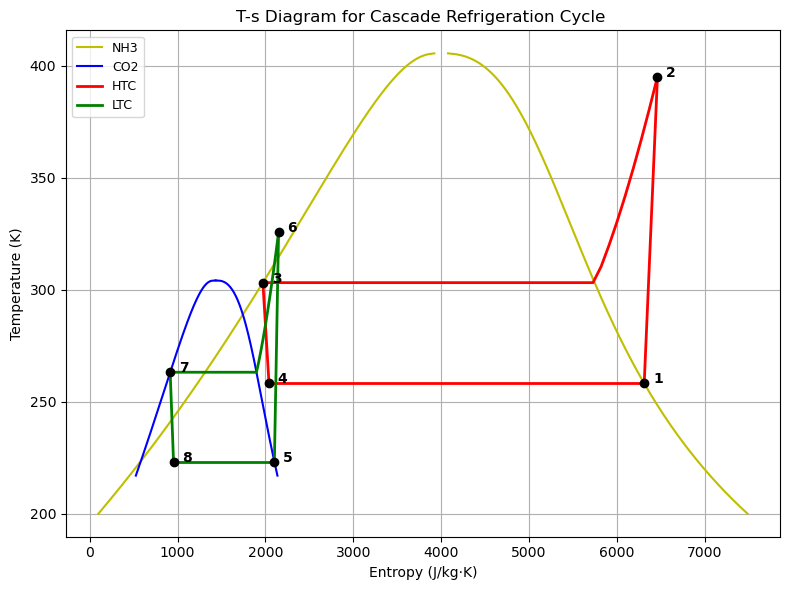

In [85]:
# T-s diagram
plt.figure(figsize=(8,6))

# Saturation lines
Tsat1 = np.linspace(200, 405.5, 500)
sliq1 = [PropsSI('S', 'T', t, 'Q', 0, fluid1) for t in Tsat1]
svap1 = [PropsSI('S', 'T', t, 'Q', 1, fluid1) for t in Tsat1]
plt.plot(sliq1, Tsat1, 'y-', label='NH3')
plt.plot(svap1, Tsat1, 'y-')

T = np.linspace(200, 405.5, 500)
for P in [P1,P2]: #MPa
    S = [PropsSI('S','P',P,'T',t,fluid1) for t in T]
    #plt.plot(S, T, 'k--')

# Saturation lines
Tsat2 = np.linspace(217 , 304.1282 , 500)
sliq2 = [PropsSI('S', 'T', t, 'Q', 0, fluid2) for t in Tsat2]
svap2 = [PropsSI('S', 'T', t, 'Q', 1, fluid2) for t in Tsat2]
plt.plot(sliq2, Tsat2, 'b-', label='CO2')
plt.plot(svap2, Tsat2, 'b-')

T_ = np.linspace(218, 250, 500)
for P in [P5,P6]: #MPa
    S = [PropsSI('S','P',P,'T',t,fluid2) for t in T_]
    #plt.plot(S, T, 'k--')

# Refrigeration cycle
plt.plot([s1, s2], [T1, T2], 'r-', lw=2, label='HTC')

S23 = np.linspace(s2, s3)
T23 = [PropsSI('T','P',P2,'S',s,fluid1) for s in S23]
plt.plot(S23,T23, 'r-', lw=2)

plt.plot([s3, s4], [T3, T4], 'r-', lw=2)
plt.plot([s4, s1], [T4, T1], 'r-', lw=2)

# Refrigeration cycle
plt.plot([s5, s6], [T5, T6], 'g-', lw=2, label='LTC')

S67 = np.linspace(s6, s7)
T67 = [PropsSI('T','P',P6,'S',s,fluid2) for s in S67]
plt.plot(S67,T67, 'g-', lw=2)

plt.plot([s7, s8], [T7, T8], 'g-', lw=2)
plt.plot([s8, s5], [T8, T5], 'g-', lw=2)



# State points
states = [(s1, T1), (s2, T2), (s3, T3), (s4, T4), (s5, T5),(s6, T6),(s7, T7), (s8, T8)]
for i, (s, T) in enumerate(states, start=1):
    plt.plot(s, T, 'ko')  # point
    plt.text(s + 100, T, f"{i}", fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel('Entropy (J/kg·K)')
plt.ylabel('Temperature (K)')
plt.title('T-s Diagram for Cascade Refrigeration Cycle ')
#plt.legend()
plt.legend(loc='upper left', fontsize=9, frameon=True)

plt.grid(True)
plt.tight_layout()
plt.show()








In [ ]:
# --- Cascade Heat Exchanger Mass Flow Balance ---
Q_CO2_rejected = h2 - h3   # heat rejected by CO2 in its condenser
Q_NH3_absorbed = h5 - h8   # heat absorbed by NH3 in its evaporator

mass_flow_ratio = Q_NH3_absorbed / Q_CO2_rejected  # m_CO2 / m_NH3

print(f"\n--- MASS FLOW RATE RATIO ---")
print(f"To balance heat at the cascade heat exchanger:")
print(f"  ṁ_CO2 / ṁ_NH3 = {mass_flow_ratio:.3f}")


--- MASS FLOW RATE RATIO ---
To balance heat at the cascade heat exchanger:
  ṁ_CO2 / ṁ_NH3 = 3.265


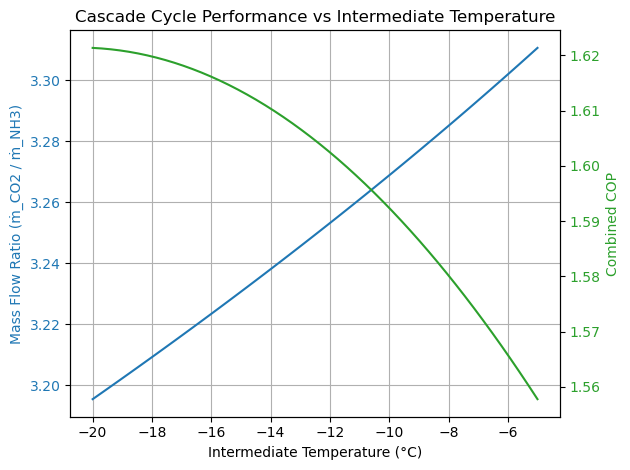

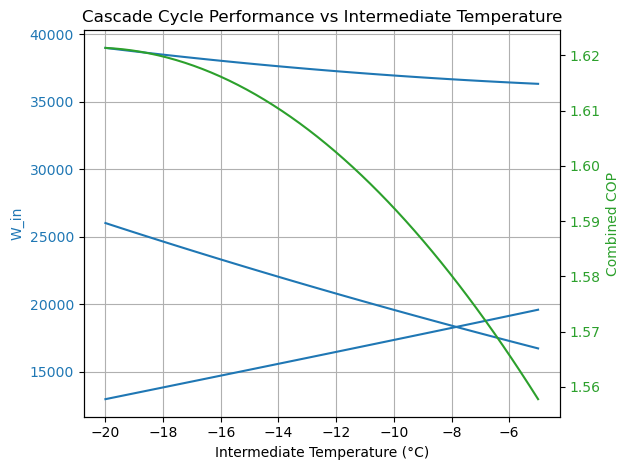

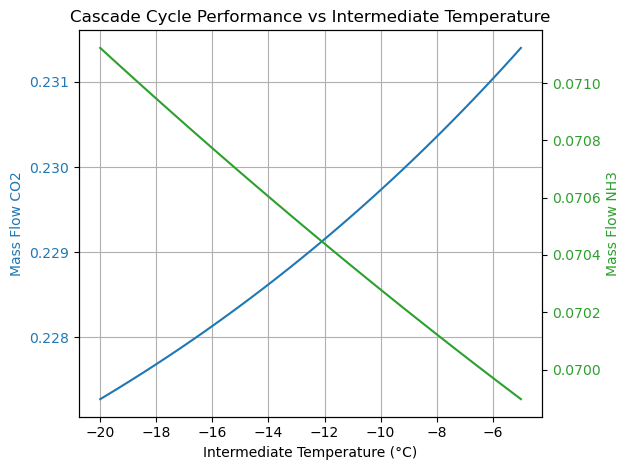

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Refrigerants
fluid_lt = 'CO2'
fluid_ht = 'Ammonia'

# Constants
T_evap_lt = -50 + 273.15   # CO2 evaporator temp (K)
T_cond_ht = 35 + 273.15    # NH3 condenser temp (K)
eff_isentropic = 0.8

# Sweep intermediate temps (cascade temp)
T_mid_range = np.linspace(-20, -5, 50) + 273.15  # from -20°C to -5°C

mass_flow_ratios = []
combined_COPs = []
combined_W_in = []
combined_W_in_lt = []
combined_W_in_ht = []
combined_m_lt= []
combined_m_ht = []

for T_mid in T_mid_range:
    try:
        # CO2 (LT cycle)
        P1 = PropsSI('P', 'T', T_evap_lt, 'Q', 1, fluid_lt)
        h1 = PropsSI('H', 'T', T_evap_lt, 'Q', 1, fluid_lt)
        h2s = PropsSI('H', 'P', PropsSI('P', 'T', T_mid, 'Q', 1, fluid_lt), 'S', PropsSI('S', 'T', T_evap_lt, 'Q', 1, fluid_lt), fluid_lt)
        h2 = h1 + (h2s - h1) / eff_isentropic
        h3 = PropsSI('H', 'T', T_mid, 'Q', 0, fluid_lt)
        h4 = h3

        q_in_lt = h1 - h4
        w_in_lt = h2 - h1
        COP_lt = q_in_lt / w_in_lt

        # NH3 (HT cycle)
        P5 = PropsSI('P', 'T', T_mid, 'Q', 1, fluid_ht)
        h5 = PropsSI('H', 'T', T_mid, 'Q', 1, fluid_ht)
        h6s = PropsSI('H', 'P', PropsSI('P', 'T', T_cond_ht, 'Q', 0, fluid_ht), 'S', PropsSI('S', 'T', T_mid, 'Q', 1, fluid_ht), fluid_ht)
        h6 = h5 + (h6s - h5) / eff_isentropic
        h7 = PropsSI('H', 'T', T_cond_ht, 'Q', 0, fluid_ht)
        h8 = h7

        q_in_ht = h5 - h8
        w_in_ht = h6 - h5
        COP_ht = q_in_ht / w_in_ht


        Q=76210 #W
        m_ht=Q/q_in_ht

        # Mass flow rate ratio (LT/HT)
        m_dot_ratio = q_in_ht / (h2 - h3)

        m_lt=m_ht*m_dot_ratio

        # Combined COP of cascade system
        total_q_in = q_in_lt
        total_w_in = w_in_lt + (w_in_ht * 1 / m_dot_ratio)  # scale NH3 work by flow ratio
        COP_total = total_q_in / total_w_in
        W_in=w_in_lt*m_lt+w_in_ht*m_ht
        W_in_ht = w_in_ht*m_ht
        W_in_lt = w_in_lt*m_lt

        mass_flow_ratios.append(m_dot_ratio)
        combined_COPs.append(COP_total)
        combined_W_in.append(W_in)
        combined_W_in_ht.append(W_in_ht)
        combined_W_in_lt.append(W_in_lt)
        combined_m_lt.append(m_lt)
        combined_m_ht.append(m_ht)


    except Exception as e:
        # Skip invalid conditions
        mass_flow_ratios.append(np.nan)
        combined_COPs.append(np.nan)
        combined_W_in.append(np.nan)
        combined_W_in_ht.append(np.nan)
        combined_W_in_lt.append(np.nan)
        combined_m_lt.append(np.nan)
        combined_m_ht.append(np.nan)

# Convert T_mid_range to °C
T_mid_range_C = T_mid_range - 273.15

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Intermediate Temperature (°C)')
ax1.set_ylabel('Mass Flow Ratio (ṁ_CO2 / ṁ_NH3)', color='tab:blue')
ax1.plot(T_mid_range_C, mass_flow_ratios, label='Mass Flow Ratio', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Second Y-axis for COP
ax2 = ax1.twinx()
ax2.set_ylabel('Combined COP', color='tab:green')
ax2.plot(T_mid_range_C, combined_COPs, label='Combined COP', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Cascade Cycle Performance vs Intermediate Temperature')
fig.tight_layout()
plt.show()


# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Intermediate Temperature (°C)')
ax1.set_ylabel('W_in', color='tab:blue')
ax1.plot(T_mid_range_C, combined_W_in, label='Combined W in', color='tab:blue')
ax1.plot(T_mid_range_C, combined_W_in_ht, label='Combined W in', color='tab:blue')
ax1.plot(T_mid_range_C, combined_W_in_lt, label='Combined W in', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Second Y-axis for COP
ax2 = ax1.twinx()
ax2.set_ylabel('Combined COP', color='tab:green')
ax2.plot(T_mid_range_C, combined_COPs, label='Combined COP', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Cascade Cycle Performance vs Intermediate Temperature')
fig.tight_layout()
plt.show()

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Intermediate Temperature (°C)')
ax1.set_ylabel('Mass Flow CO2', color='tab:blue')
ax1.plot(T_mid_range_C, combined_m_lt, label='Mass Flow CO2', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Second Y-axis for COP
ax2 = ax1.twinx()
ax2.set_ylabel('Mass Flow NH3', color='tab:green')
ax2.plot(T_mid_range_C, combined_m_ht, label='Mass Flow NH3', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Cascade Cycle Performance vs Intermediate Temperature')
fig.tight_layout()
plt.show()

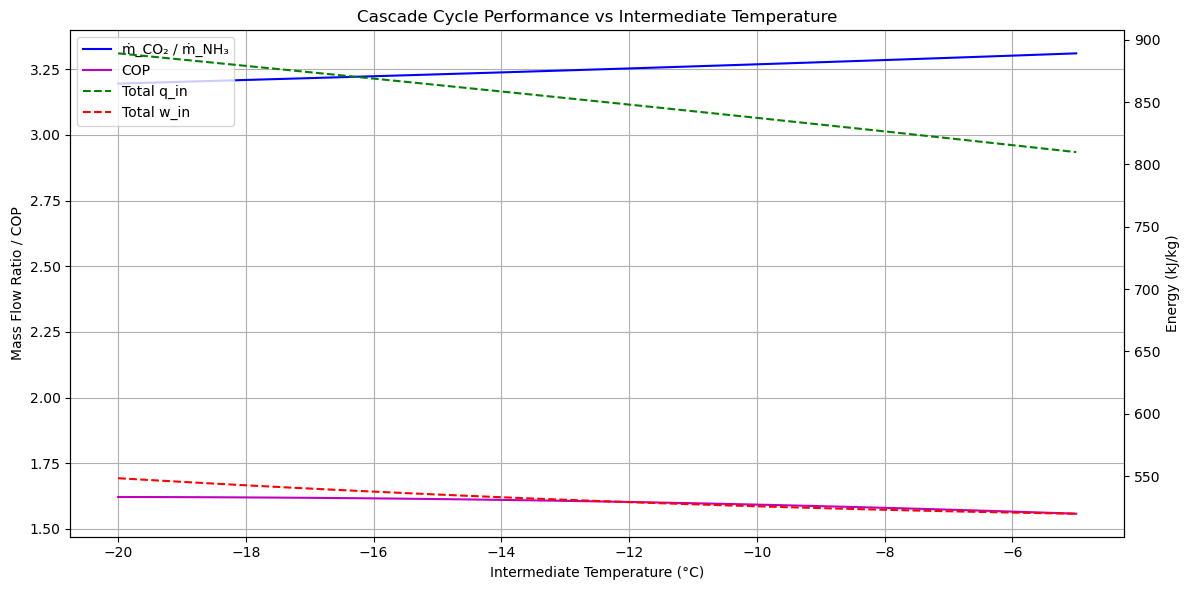

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Fluids and constants
fluid_lt = 'CO2'
fluid_ht = 'Ammonia'
eff_isentropic = 0.8
T_evap_CO2 = -50 + 273.15
T_cond_NH3 = 35 + 273.15

# Range of intermediate temperatures (cascade temp)
T_mids = np.linspace(-20 + 273.15, -5 + 273.15, 50)  # in K

# Arrays to store results
mass_flow_ratios = []
total_q_in = []
total_w_in = []
COP_total = []

for T_mid in T_mids:
    # --- CO2 Cycle (LT) ---
    P1 = PropsSI('P', 'T', T_evap_CO2, 'Q', 1, fluid_lt)
    h1 = PropsSI('H', 'T', T_evap_CO2, 'Q', 1, fluid_lt)
    s1 = PropsSI('S', 'T', T_evap_CO2, 'Q', 1, fluid_lt)

    P2 = PropsSI('P', 'T', T_mid, 'Q', 1, fluid_lt)
    h2s = PropsSI('H', 'P', P2, 'S', s1, fluid_lt)
    h2 = h1 + (h2s - h1) / eff_isentropic
    h3 = PropsSI('H', 'T', T_mid, 'Q', 0, fluid_lt)
    h4 = h3

    q_in_CO2 = h1 - h4
    w_in_CO2 = h2 - h1
    q_rej_CO2 = h2 - h3

    # --- NH3 Cycle (HT) ---
    P5 = PropsSI('P', 'T', T_mid, 'Q', 1, fluid_ht)
    h5 = PropsSI('H', 'T', T_mid, 'Q', 1, fluid_ht)
    s5 = PropsSI('S', 'T', T_mid, 'Q', 1, fluid_ht)

    P6 = PropsSI('P', 'T', T_cond_NH3, 'Q', 0, fluid_ht)
    h6s = PropsSI('H', 'P', P6, 'S', s5, fluid_ht)
    h6 = h5 + (h6s - h5) / eff_isentropic
    h7 = PropsSI('H', 'T', T_cond_NH3, 'Q', 0, fluid_ht)
    h8 = h7

    q_in_NH3 = h5 - h8
    w_in_NH3 = h6 - h5

    # --- Mass flow rate ratio ---
    m_ratio = q_in_NH3 / q_rej_CO2

    # Normalize to m_NH3 = 1 kg/s
    m_NH3 = 1
    m_CO2 = m_ratio

    total_q = m_CO2 * q_in_CO2
    total_w = m_CO2 * w_in_CO2 + m_NH3 * w_in_NH3
    cop = total_q / total_w

    # Store results
    mass_flow_ratios.append(m_ratio)
    total_q_in.append(total_q / 1000)  # kJ/kg
    total_w_in.append(total_w / 1000)  # kJ/kg
    COP_total.append(cop)

# Convert to Celsius for x-axis
T_C = T_mids - 273.15

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: mass flow ratio and COP
ax1.set_xlabel('Intermediate Temperature (°C)')
ax1.set_ylabel('Mass Flow Ratio / COP')
ax1.plot(T_C, mass_flow_ratios, 'b-', label='ṁ_CO₂ / ṁ_NH₃')
ax1.plot(T_C, COP_total, 'm-', label='COP')
ax1.tick_params(axis='y')
ax1.grid(True)

# Right axis: q_in and w_in
ax2 = ax1.twinx()
ax2.set_ylabel('Energy (kJ/kg)')
ax2.plot(T_C, total_q_in, 'g--', label='Total q_in')
ax2.plot(T_C, total_w_in, 'r--', label='Total w_in')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Cascade Cycle Performance vs Intermediate Temperature')
plt.tight_layout()
plt.show()
